# Imports

In [1]:
import sys
import pkg_resources

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

if "nibabel" not in installed_packages:
    %pip install nibabel
    
if 'opencv-python' not in installed_packages:
    %pip install opencv-python
    
if 'circle-fit' not in installed_packages:
    %pip install circle-fit

In [2]:
import circle_fit as cf
import cv2
import imageio
import math
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import scipy.io
import statistics

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Functions

In [3]:
def resize_coords(old_coords, old_size, new_size):
    new_coords = []
    Rx = new_size[0]/old_size[0]
    Ry = new_size[1]/old_size[1]
    for i, old_coord in enumerate(old_coords):
        new_coords[i] = [round(Rx*old_coord[0]), round(Ry*old_coord[1])]
    return new_coords


def calc_arc_length(p1, p2, c):
    """
    Calculate the clockwise arc length from p1 to p2 with center c
    """
    x1 = p1[0]; y1 = p1[1]     # Start point
    xc = c[0]; yc = c[1]       # Center point
    r = math.sqrt((x1-xc)**2 + (y1-yc)**2)
    # End point
    x2 = xc+r*(p2[0]-xc)/math.sqrt((p2[0]-xc)**2+(p2[1]-yc)**2)
    y2 = yc+r*(p2[1]-yc)/math.sqrt((p2[1]-yc)**2+(p2[0]-xc)**2)
    x3 = 2*xc-x1; y3 = 2*yc-y1 # Point opposite start point
    d = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    theta = math.acos(1 - (d**2)/(2*r**2))
    if x2 > x3:   # This only works if p1 is bottom point now
        theta = 2*math.pi-theta
    arc_length = r*theta
    print(p1, p2, round(arc_length, 3), round(theta, 2), round(d,2), round(r,2))
    return arc_length


def coord_from_arc_length(p1, c, arc_length):
    """
    Calculate the coordinate p2 with arc length from p1
    """
    x1 = p1[0]; y1 = p1[1]     # Start point
    xc = c[0]; yc = c[1]       # Center point
    r = math.sqrt((x1-xc)**2 + (y1-yc)**2)
    circum = 2*math.pi*r
    theta = 2*math.pi*arc_length/circum
    print(theta)
    coord = [x1-r*math.sin(theta), y1-r*(1-math.cos(theta))]
    return coord

# Data dir Info

In [4]:
data_dir = '/Users/rykochis/Desktop/UCLA22-23/BE223A/BrainRegistration/Data'
sample1 = 'DBS_rS01/fluoro01.tif'
sample2 = 'DBS_bT20/fluoro20.tif'
sample3 = 'DBS_IT04/IM-0001-0001.tif'
sample4 = 'DBS_IT13/fluoro13.tif'
sample5 = 'DBS_IT14/fluoro14.tif'
solution1 = 'DBS_rS01/Electrode_Locations_JWC(fluoro2)/alignment.JPG'
solution2 = 'DBS_bT20/Electrode_Locations_JWC/alignment.JPG'
solution4 = 'DBS_IT13/Electrode_Locations_JWC/alignment.JPG'
solution5 = 'DBS_IT14/Electrode_Locations_JWC/alignment.JPG'

# Find Electrodes
Sample 1 is the main working sample and what values are hard coded for below

CV2 Blobs:  4


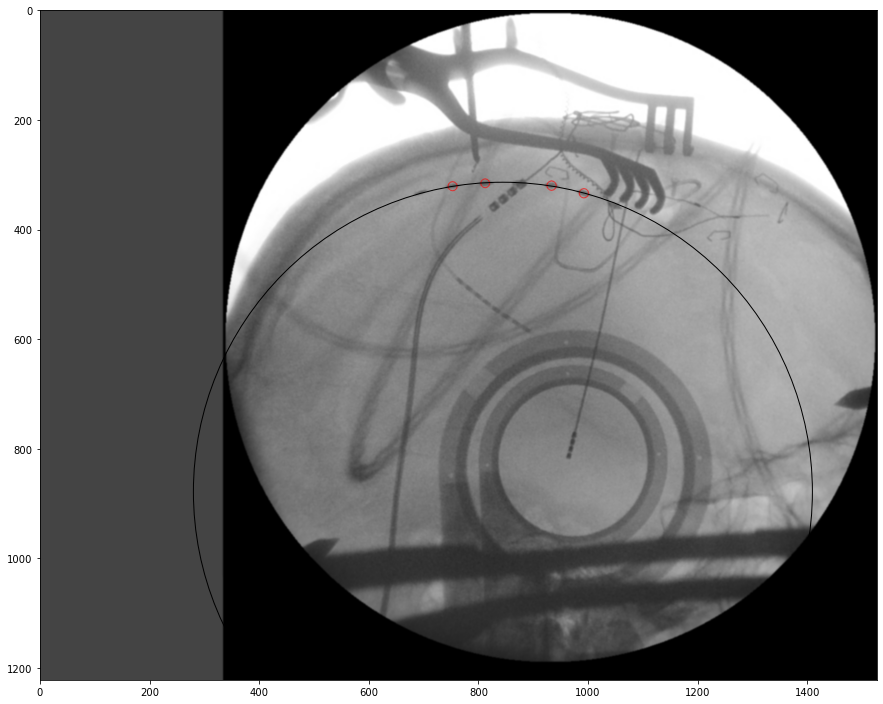

In [8]:
num_electrodes = 8

# Load fluoroscopy image and convert to greyscale
fig, ax = plt.subplots(figsize=(15, 15))
fluoro = imageio.imread('/'.join([data_dir, sample1]))
gray = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)

kernel_size = 5
gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Set our filtering parameters
# Initialize parameter setting using cv2.SimpleBlobDetector
# Guide at https://www.geeksforgeeks.org/find-circles-and-ellipses-in-an-image-using-opencv-python/
params = cv2.SimpleBlobDetector_Params()
# Set Area filtering parameters
params.filterByArea = True
params.minArea = 150                           # Best 150 > A > 700
params.maxArea = 600
# Set Circularity filtering parameters
params.filterByCircularity = True
params.minCircularity = 0.4                    # Best 0.4 > C > 0.8
params.maxCircularity = 0.8
# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.7                      # Best 0.7 > I > 0.97
params.maxConvexity = 0.97
# Set Inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.1                   # Best 0.1 > I > 0.4
params.maxInertiaRatio = 0.4
# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)
     
# Detect blobs
keypoints = detector.detect(gray)
ECoG_Coords = [keypoints[point].pt for point in range(0,len(keypoints))]
ECoG_Coords_x = [coord[0] for coord in ECoG_Coords]
ECoG_Coords_y = [coord[1] for coord in ECoG_Coords]
 
# Draw cv2 blobs on our image as red circles
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(gray, keypoints, blank, (255, 0, 0),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
ax.imshow(blobs)
number_of_blobs = len(keypoints)
print('CV2 Blobs: ', number_of_blobs)

# Show best fit circle from https://github.com/AlliedToasters/circle-fit
xc,yc,r,s = cf.least_squares_circle(ECoG_Coords)

num_refits = 0
while s > 150:       # Find the bad point(s)
    num_refits = num_refits + 1
    bad_indexes = []
    for i in range(len(keypoints)):
        ECoG_Coords_subset = ECoG_Coords[:i] + ECoG_Coords[i+1 :]
        
        xc_subset,yc_subset,r_subset,s_subset = cf.least_squares_circle(ECoG_Coords_subset)
        if s_subset < (s-1000):  # Keep the point
            bad_indexes.append(i)
    
    # Remake best fit circle
    ECoG_Coords = [i for j, i in enumerate(ECoG_Coords) if j not in bad_indexes]
    xc,yc,r,s = cf.least_squares_circle(ECoG_Coords)
    
    # Only attempt this a maximum of 4 times
    if num_refits > 3:
        break

# If there are only 2 ecog electrodes this may find another but just hard codes y-axis drop
if number_of_blobs == 2:
    ECoG_sep = math.dist(ECoG_Coords[0],ECoG_Coords[1])
    ave_ECoG_size = sum([keypoints[point].size for point in range(0,len(keypoints))])/len(keypoints)

    # Predict the next electrode
    left_keypoint = keypoints[0] if keypoints[0].pt[0] < keypoints[1].pt[0] else keypoints[1]
    left_ECoG = [round(left_keypoint.pt[0]), round(left_keypoint.pt[1])]
    right_keypoint = keypoints[0] if keypoints[0].pt[0] > keypoints[1].pt[0] else keypoints[1]
    right_ECoG = [round(right_keypoint.pt[0]), round(right_keypoint.pt[1])]

    left_predict = [ECoG_Coords[0][0]-(ECoG_Coords[1][0]-ECoG_Coords[0][0]),
                    ECoG_Coords[0][1]-(ECoG_Coords[1][1]-ECoG_Coords[0][1])]
    left_predict_space = gray[math.floor(left_ECoG[1]-ave_ECoG_size*2):math.ceil(left_ECoG[1]+ave_ECoG_size*2),
                              math.floor(left_ECoG[0]-ave_ECoG_size*2):math.ceil(left_ECoG[0]+ave_ECoG_size*2)]
    right_predict = [ECoG_Coords[1][0]+(ECoG_Coords[1][0]-ECoG_Coords[0][0]),
                     ECoG_Coords[1][1]+(ECoG_Coords[1][1]-ECoG_Coords[0][1])]
    right_predict_space = gray[math.floor(right_ECoG[1]-ave_ECoG_size/2):math.ceil(right_ECoG[1]+ave_ECoG_size/2),
                               math.floor(right_ECoG[0]-ave_ECoG_size/2):math.ceil(right_ECoG[0]+ave_ECoG_size/2)]

    left_predict_shade = left_predict_space.mean(axis=0).mean(axis=0)
    right_predict_shade = right_predict_space.mean(axis=0).mean(axis=0)

    next_ECoG = left_predict if left_predict_shade > right_predict_shade else right_predict
    next_ECoG = [round(next_ECoG[0]), round(next_ECoG[1])+4]
    next_ECoG_space = fluoro[math.floor(next_ECoG[1]-ave_ECoG_size):math.ceil(next_ECoG[1]+ave_ECoG_size),
                             math.floor(next_ECoG[0]-ave_ECoG_size):math.ceil(next_ECoG[0]+ave_ECoG_size)]
    ECoG_Coords.append(tuple(next_ECoG))
    
    # Create new best fit circle
    xc,yc,r,s = cf.least_squares_circle(ECoG_Coords)

# Show final best fit circle
fit_circle = plt.Circle((xc,yc), radius=r, fill=False)
ax.add_patch(fit_circle)

# Compare with Truths

[360.1040462267898, 868.5839185536238] (325.9167175292969, 148.7979278564453) 1101.349 3.05 722.22 361.52
[360.1040462267898, 868.5839185536238] (379.0, 145.37037658691406) 1154.612 3.19 722.79 361.52
[360.1040462267898, 868.5839185536238] (484.8496398925781, 165.9714813232422) 1262.494 3.49 711.95 361.52
[360.1040462267898, 868.5839185536238] (456.0400695800781, 160.8632354736328) 1233.47 3.41 716.44 361.52
[360.1040462267898, 868.5839185536238] (433.09942626953125, 153.8279571533203) 1209.411 3.35 719.29 361.52
[360.1040462267898, 868.5839185536238] (404.91424560546875, 147.89015197753906) 1180.613 3.27 721.64 361.52
[360.1040462267898, 868.5839185536238] (351.192626953125, 143.7353057861328) 1126.877 3.12 722.98 361.52
(325.9167175292969, 148.7979278564453) 1101.3486897487953
(379.0, 145.37037658691406) 1154.6115028837094
(484.8496398925781, 165.9714813232422) 1262.4942716671146
(456.0400695800781, 160.8632354736328) 1233.4697450708586
(433.09942626953125, 153.8279571533203) 1209.41

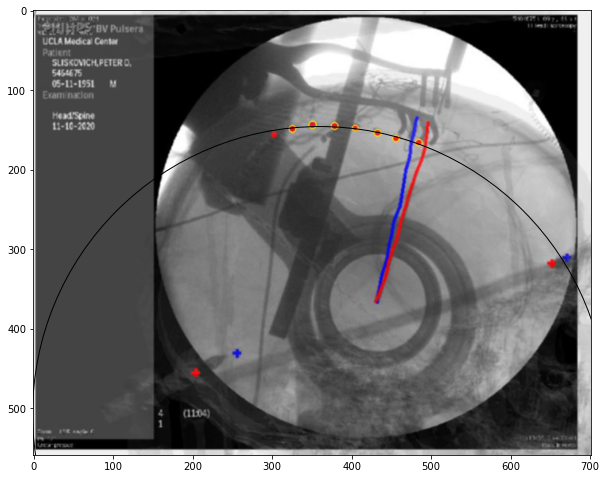

In [9]:
# Import, convert, and blur image
img = imageio.imread('/'.join([data_dir, solution1]))
img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
kernel_size = 3
img = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)

# lower mask (0-10)
lower_red = np.array([100,50,50])
upper_red = np.array([130,255,255])
mask = cv2.inRange(img_hsv, lower_red, upper_red)

# set output img to zero everywhere except my mask
output_img = img.copy()
output_img[np.where(mask==0)] = 0

# Set our filtering parameters
# Initialize parameter setting using cv2.SimpleBlobDetector
# Guide at https://www.geeksforgeeks.org/find-circles-and-ellipses-in-an-image-using-opencv-python/
params = cv2.SimpleBlobDetector_Params()
# Set Area filtering parameters
params.filterByArea = True
params.minArea = 10                            # Best 150 > A > 700
params.maxArea = 100
# Set Circularity filtering parameters
params.filterByCircularity = True
params.minCircularity = 0.1                    # Best 0.4 > C > 0.8
params.maxCircularity = 1
# Set Convexity filtering parameters
params.filterByConvexity = True
params.minConvexity = 0.9                      # Best 0.7 > I > 0.97
params.maxConvexity = 1
# Set Inertia filtering parameters
params.filterByInertia = True
params.minInertiaRatio = 0.1                   # Best 0.1 > I > 0.4
params.maxInertiaRatio = 1
# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)
     
# Detect blobs
keypoints = detector.detect(output_img)
ECoG_Coords = [keypoints[point].pt for point in range(0,len(keypoints))]
ECoG_Coords_x = [coord[0] for coord in ECoG_Coords]
ECoG_Coords_y = [coord[1] for coord in ECoG_Coords]
ave_ECoG_size = sum([keypoints[point].size for point in range(0,len(keypoints))])/len(keypoints)
 
# Draw cv2 blobs on our image as red circles
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(output_img, keypoints, blank, (255, 255, 0),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Create best fit circle
xc,yc,r,s = cf.least_squares_circle(ECoG_Coords)

# Get arc lengths along fit circle from circle bottom
circle_bottom = [xc, yc+r]
c = [xc,yc]  # Fit circle center point
arc_lengths = []  # Initialize coordinate arc lengths
for i in range(len(keypoints)):
    arc_lengths.append(calc_arc_length(circle_bottom, keypoints[i].pt, c))

# Remove coordinates whose arc lengths are far away
#  This may remove true coordinates on edges but they are easier to put back
conf_coords = []
arc_lengths_final = []
ave = statistics.mean(arc_lengths)
std = statistics.stdev(arc_lengths)
for i in range(len(keypoints)):
    zscore = (arc_lengths[i]-ave)/std
    if zscore < 1.5:
        conf_coords.append(keypoints[i].pt)
        arc_lengths_final.append(arc_lengths[i])
        print(keypoints[i].pt, arc_lengths[i])

# Fill in holes
if len(conf_coords) < num_electrodes:
    zipped = list(zip(arc_lengths_final,conf_coords))
    zipped.sort()
    sorted_coords = [truth for _,truth in zipped]
    sorted_arcs = [length for length,_ in zipped]
    diffs = [x-sorted_arcs[i-1] for i,x in enumerate(sorted_arcs)][1:]

    min_diff = min(diffs)
    print(min_diff)
    new_arcs = []
    for i in range(1,len(sorted_arcs)):
        # If there is room for 2+ electrodes, add more between
        if min_diff*1.7 <= diffs[i-1]:
            fill_arcs = np.linspace(arc_lengths[i-1], arc_lengths[i], num=round(diffs[i-1]/min_diff)+1)[1:-1]
            new_arcs.append(fill_arcs)
    # Flatten list of lists
    new_arcs = [item for sublist in new_arcs for item in sublist]
    new_electrodes = [coord_from_arc_length(circle_bottom, c, arc_length) for arc_length in new_arcs]

## Plots
# CB blobs (yellow)
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img)
blank = np.zeros((1, 1))
blobs = cv2.drawKeypoints(img, keypoints, blank, (255, 225, 0),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax.imshow(blobs)
# Fit circle (black)
fit_circle = plt.Circle((xc,yc), radius=r, fill=False)
ax.add_patch(fit_circle)
# Added points (green)
for point in new_electrodes:
    guess_circle = plt.Circle(point, radius=ave_ECoG_size, fill=False, color='green')
    ax.add_patch(guess_circle)

# Find DBS Lead
No work has been done on this function yet, all focused on ECoG electrodes

In [ ]:
dbs = np.array([922, 805])

# Find Pintips
No work has been done on this function yet, all focused on ECoG electrodes

In [ ]:
pin_tips = np.array([[ 542., 1019.],
                     [1399.,  539.]])